In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
from matplotlib import pyplot as plt
from sklearn import metrics

## Implementacja neuronu

In [27]:
from abc import ABC, abstractmethod
import logging

class Neuron(ABC):
    def __init__(self, weights: list) -> None:
        self.weights = weights
        self.output = 0
        self.delta = 0
        if len(weights) < 2:
            logging.warning("Less than 2 weights. Are you sure?")
    
    def __repr__(self) -> str:
        return "%s(weights: %s, output: %s, delta: %s)" % (self.name(), str(self.weights), str(self.output), str(self.delta))
            
    @abstractmethod
    def evaluate(self, input: list) -> float:
        pass
    
    @abstractmethod
    def name(self) -> str:
        pass
    
    @abstractmethod
    def derivative(self, output: float) -> float:
        pass
    
    def add_one(l: list) -> list:
        tmp = [1]
        tmp.extend(l)
        return tmp
    
    def dot(a: list, b: list) -> float:
        tmp = min(len(a), len(b))
        return np.dot(a[:tmp], b[:tmp])

    
# pierwsza waga to waga biasu
class LinearNeuron(Neuron):
    def evaluate(self, input: list) -> float:
        self.output = Neuron.dot(self.weights, Neuron.add_one(input))
        return self.output
    
    def name(self) -> str:
        return "LinearNeuron"
    
    def derivative(self, output: float) -> float:
        return 1.0
        

class SigmoidNeuron(Neuron):
    def evaluate(self, input: list) -> float:
        x = Neuron.dot(self.weights, Neuron.add_one(input))
        self.output = math.e ** x / (1 + math.e ** x)
        return self.output
    
    def name(self) -> str:
        return "SigmoidNeuron"
    
    def derivative(self, output: float) -> float:
        return output * (1.0 - output)

# tests

assert Neuron.dot([2,3], [5]) == 10
assert Neuron.dot([2,3], [4,5,6]) == 23

linearneuron = LinearNeuron([1,2,3])
assert linearneuron.evaluate([1,2,3]) == 9
assert linearneuron.evaluate([2,3]) == 14

sigmoidneuron = SigmoidNeuron([1, 2])
assert sigmoidneuron.evaluate([1]) == math.e ** 3 / (1 + math.e ** 3)
print(linearneuron)
print(sigmoidneuron)

LinearNeuron(weights: [1, 2, 3], output: 14, delta: 0)
SigmoidNeuron(weights: [1, 2], output: 0.9525741268224333, delta: 0)


## Implementacja warstwy

In [24]:
class Layer(ABC):
    def __init__(self) -> None:
        self.neurons = []
    
    @abstractmethod
    def __init__(self, num: int, weights: list) -> None:
        pass
        
    def addNeuron(self, neuron: Neuron) -> None:
        self.neurons.append(neuron)
        
    def evaluate(self, input: list) -> list:
        return [neuron.evaluate(input) for neuron in self.neurons]
    
    def __repr__(self) -> str:
        return "Layer(" + str(self.neurons) + ")"
    

class LinearLayer(Layer):
    def __init__(self, num: int, weights: list) -> None:
        assert len(weights) == num, "Invalid matrix dimension"
        self.neurons = [LinearNeuron(w) for w in weights]
    
class SigmoidLayer(Layer):
    def __init__(self, num: int, weights: list) -> None:
        assert len(weights) == num, "Invalid matrix dimension"
        self.neurons = [SigmoidNeuron(w) for w in weights]

# tests
layer1 = LinearLayer(1, [[1, 2]])
assert layer1.evaluate([5]) == [11]
layer1.addNeuron(LinearNeuron([2, 3]))
assert layer1.evaluate([5]) == [11, 17]

layer2 = LinearLayer(2, [[1,2], [2, 3]])
assert layer2.evaluate([5]) == [11, 17]
print(layer2)

Layer([LinearNeuron(weights: [1, 2], output: 11, delta: 0), LinearNeuron(weights: [2, 3], output: 17, delta: 0)])


## Implementacja sieci

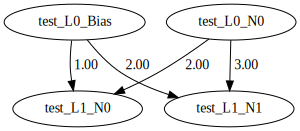

In [52]:
from graphviz import Digraph
import random 

class Network:
    def __init__(self) -> None:
        self.layers = []
    
    def __repr__(self) -> str:
        return "Network(" + str(self.layers) + ")"
    
    def __init__(self, layer_types: list, size: list, weights=None, gen_type="0|1") -> None:
        assert len(layer_types) == len(size) - 1, "Invalid matrix dimension"
        self.layers = []
        for i, layer_type in enumerate(layer_types):
            if layer_type == "sigmoid":
                self.addLayerBack(SigmoidLayer(size[i + 1], weights[i] if weights else Network.generate(gen_type, (size[i + 1], size[i] + 1))))
            elif layer_type == "linear":
                self.addLayerBack(LinearLayer(size[i + 1], weights[i] if weights else Network.generate(gen_type, (size[i + 1], size[i] + 1))))
            else:
                logging.error("Invalid layer type")
    
    @staticmethod
    def batch_partition(list_in, n):
        random.shuffle(list_in)
        return [list_in[(i * n):(i * n + n)] for i in range(int((len(list_in) + n - 1) / n))]
        
    def generate(gen_type: str, n: tuple) -> np.array:
        if gen_type == "0|1":
            return np.random.uniform(0, 1, n)
        elif gen_type == "-1|1":
            return np.random.uniform(-1, 1, n)
        elif gen_type == "norm":
            return np.random.normal(0, 1, n)
        
    
    def addLayerBack(self, layer: Layer) -> None:
        self.layers.append(layer)
    
    def forward(self, x: list) -> list:
        input = x
        for layer in self.layers:
            out = []
            for val in input:
                tmp = layer.evaluate(val)
                out.append(tmp)
            input = out
        return input
    
    def draw(self, prefix='', graph=None) -> None:
        g = Digraph(format='svg', name="neural network")
        if graph is not None:
            g = graph
        for idx, layer in enumerate(self.layers):
            current_id = idx + 1
            # create bias neuron
            bias_name = '%s_L%s_Bias' % (prefix, idx)
            g.node(bias_name)
            for n_i, neuron in enumerate(layer.neurons):
                # create dot for neuron
                neuron_name = '%s_L%s_N%s' % (prefix, current_id, n_i)
                g.node(neuron_name)
                # create dots and edges for parents
                for w_i, weight in enumerate(neuron.weights):
                    if w_i == 0:
                        g.edge(bias_name, neuron_name, label=format(weight, '.2f'))
                    else:
                        p_name = '%s_L%s_N%s' % (prefix, idx, w_i - 1)
                        g.node(p_name)
                        g.edge(p_name, neuron_name, label=format(weight, '.2f'))
        return g
            
    def backward_propagate_error(self, expected):
        for i in reversed(range(len(self.layers))):
            layer = self.layers[i]
            errors = list()
            if i != len(self.layers) - 1:
                for j in range(len(layer.neurons)):
                    error = 0.0
                    for neuron in self.layers[i + 1].neurons:
                        error += (neuron.weights[j + 1] * neuron.delta)
                    errors.append(error)
            else:
                for j, neuron in enumerate(layer.neurons):
                    errors.append(expected[j] - neuron.output)
            for j in range(len(layer.neurons)):
                neuron = layer.neurons[j]
                neuron.delta = errors[j] * neuron.derivative(neuron.output)
                
    def update_weights(self, row, l_rate):
        for i in range(len(self.layers)):
            inputs = row[:-1]
            if i != 0:
                inputs = [neuron.output for neuron in self.layers[i - 1].neurons]
            for neuron in self.layers[i].neurons:
                for j in range(len(inputs)):
                    neuron.weights[j + 1] += l_rate * neuron['delta'] * inputs[j]
                neuron.weights[0] += l_rate * neuron['delta']
    
    def train_network(self, train_data: list, l_rate=1e-3, n_epoch=5, n_outputs, batch_size=1) -> None:
        for epoch in range(n_epoch):
            sum_error = 0
            for row in train:
                outputs = self.forward([row[:-n_outputs]])
                expected = row[-n_outputs]
                sum_error += sum([(expected[i]-outputs[0][i])**2 for i in range(len(expected))])
                self.backward_propagate_error(expected)
                self.update_weights(network, row, l_rate)
#             print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, l_rate, sum_error)
        

# tests
network = Network(["linear"], [1, 1], [[[1,2,3]]])
assert network.forward([[2,3]]) == [[14]]

network2 = Network(["linear"], [1, 2], [
        [[1,2], [2, 3]]
])
assert network2.forward([[5]]) == [[11, 17]]
network2.draw("test")
# https://machinelearningmastery.com/implement-backpropagation-algorithm-scratch-python/

In [53]:
test = Network(["sigmoid", "sigmoid"], [2,1,2], [
        [[0.76377, 0.1343, 0.8474]],
        [[0.4954, 0.255], [0.65159, 0.44949]]
    ])
row = [[1, 0]]
test.layers[0].neurons[0].output = 0.7105
test.layers[1].neurons[0].output = 0.6213
test.layers[1].neurons[1].output = 0.6573
expected = [0, 1]
test.backward_propagate_error(expected)
print(test)

Network([Layer([SigmoidNeuron(weights: [0.76377, 0.1343, 0.8474], output: 0.7105, delta: -0.0005303029745276928)]), Layer([SigmoidNeuron(weights: [0.4954, 0.255], output: 0.6213, delta: -0.146183384403), SigmoidNeuron(weights: [0.65159, 0.44949], output: 0.6573, delta: 0.077195474517)])])


In [56]:
a = [1,2,3,4,5,6,7]
Network.batch_partition(a, 1)

[[5], [1], [2], [3], [6], [7], [4]]

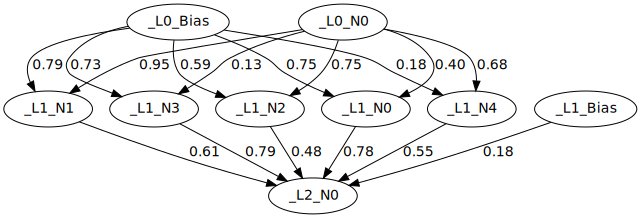

In [71]:
network3 = Network(["sigmoid", "linear"], [1, 5, 1])
network3.draw()

# Zbiór square-simple

In [25]:
train_df = pd.read_csv('./mio1/regression/square-simple-training.csv', index_col=0)
test_df = pd.read_csv('./mio1/regression/square-simple-test.csv', index_col=0)

### jedna warstwa ukryta, 5 neuronów

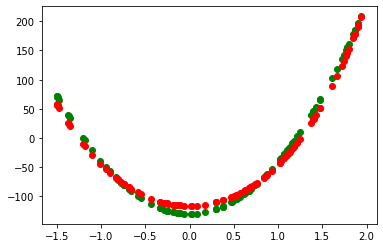

In [72]:
mlp = Network(["sigmoid", "linear"], [1,5,1], [
    [
        [5, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [-5, 1]
    ],
    [
        [9750,-10000,0,0,0,10000]
    ]])
y_pred = mlp.forward(np.expand_dims(train_df['x'], 1))
y_pred = np.squeeze(y_pred)
plt.scatter(train_df['x'], train_df['y'], color='green')
plt.scatter(train_df['x'], y_pred, color='red')

##### Wynik na zbiorze treningowym

In [25]:
metrics.mean_absolute_error(train_df['y'], y_pred)

8.534895752851826

##### Wynik na zbiorze testowym

In [74]:
y_pred = mlp.forward(np.expand_dims(test_df['x'], 1))
y_pred = np.squeeze(y_pred)
metrics.mean_absolute_error(test_df['y'], y_pred)

79.42465322775806

# Zbiór steps-large

In [75]:
train_df = pd.read_csv('./mio1/regression/steps-large-training.csv', index_col=0)
test_df = pd.read_csv('./mio1/regression/steps-large-test.csv', index_col=0)

### Jedna warstwa ukryta, 10 neuronów

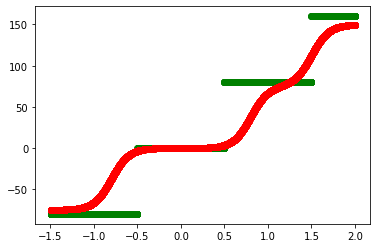

In [76]:
mlp = Network(["sigmoid", "linear"], [1, 10, 1], [
    [
        [-8, 10],
        [-15, 10],
        [8, 10],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1]
    ],
    [
        [-75, 75, 75, 75, 0, 0, 0, 0, 0, 0, 0]
    ]])
y_pred = mlp.forward(np.expand_dims(train_df['x'], 1))
y_pred = np.squeeze(y_pred)
plt.scatter(train_df['x'], train_df['y'], color='green')
plt.scatter(train_df['x'], y_pred, color='red')

##### Wynik na zbiorze treningowym

In [77]:
metrics.mean_absolute_error(train_df['y'], y_pred)

19.285010695832717

##### Wynik na zbiorze testowym

In [78]:
y_pred = mlp.forward(np.expand_dims(test_df['x'], 1))
y_pred = np.squeeze(y_pred)
metrics.mean_absolute_error(test_df['y'], y_pred)

19.104502371942342

### Dwie warstwy ukryte, po 5 neuronów każda

In [79]:
mlp = Network(["sigmoid", "sigmoid", "linear"], [1, 5, 5, 1], [
    [
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1]
    ],
    [
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1]
    ],
    [
        [-75, 75, 75, 75, 0, 0]
    ]])

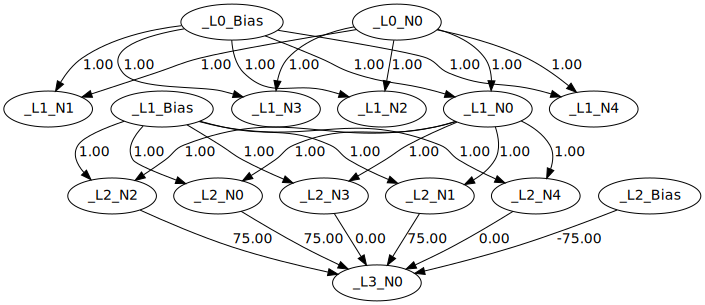

In [80]:
mlp.draw()